In [1]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')#<<<<----CHANGE HERE DEPEINDING ON YOUR PATH
import functions as fun
import reg_icp as ricp
import emcm 

In [2]:
# Loading data sets
filtered_cell_profiler_B = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/filtered_cell_profiler_B.csv')
print(f'There are {filtered_cell_profiler_B.shape} rows and cols in the Batch B')

There are (5160, 285) rows and cols in the Batch B


## Now training

### 1. Creating training and tests sets

In [3]:
# We get the input values
X_filtered =  filtered_cell_profiler_B.iloc[:,:-1].to_numpy()

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered = X_filtered.to_numpy()

# Output values
y = 1000*filtered_cell_profiler_B.iloc[:,-1].to_numpy()

In [4]:
# Parameters for ML model
train_size = 0.1
test_size = 0.3

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [5]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 361
The inicial pool set has size 3251
The inicial test set has size 1548


In [6]:
#Target from supervised machine learning
target = 0.4964
linear_model_v2 = Ridge(alpha=0.1, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v2 = []

#Fit model to initial data
linear_model_v2.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v2.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v2.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v2, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v2.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v2.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v2.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        #Saving model
        filename = "".join([str(linear_model_v2),'.sav'])
        pickle.dump(linear_model_v2, open(filename, 'wb'))
        break
    
    if len(x_pool) == 0:
        #Saving model
        filename = "".join([str(linear_model_v2),'.sav'])
        pickle.dump(linear_model_v2, open(filename, 'wb'))

Inside AL
Accuracy after query 100: 0.7471
Accuracy after query 200: 0.7132
Accuracy after query 300: 0.6554
Accuracy after query 400: 0.6331
Accuracy after query 500: 0.5932
Accuracy after query 600: 0.5751
Accuracy after query 700: 0.5989
Accuracy after query 800: 0.5745
Accuracy after query 900: 0.5687
Accuracy after query 1000: 0.5570
Accuracy after query 1100: 0.5464
Accuracy after query 1200: 0.5444
Accuracy after query 1300: 0.5331
Accuracy after query 1400: 0.5277
Accuracy after query 1500: 0.5229
Accuracy after query 1600: 0.5222
Accuracy after query 1700: 0.5170
Accuracy after query 1800: 0.5182
Accuracy after query 1900: 0.5167
Accuracy after query 2000: 0.5179
Accuracy after query 2100: 0.5131
Accuracy after query 2200: 0.5112
Accuracy after query 2300: 0.5137
Accuracy after query 2400: 0.5116
Accuracy after query 2500: 0.5073
Target reached! 
 Number of queries performed 2595


In [7]:
# Save results for plots
d_v2_BatchB = {'performance_history_v2':performance_history_v2,'collections':collections}
with open('d_v2_BatchB.pkl', 'wb') as f:
    pickle.dump(d_v2_BatchB, f)
        

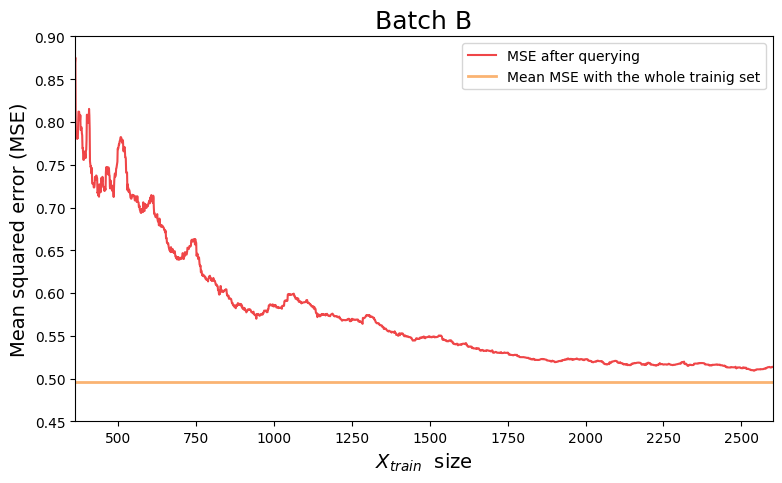

In [24]:
xxx = np.arange(361, 2597+360, 1)
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(xxx, performance_history_v2, color=[.937, .275, .282], linewidth=1.5)
ax.set_ylim([0.45, 0.9])
ax.set_xlim([361, 2600])
plt.axhline(y = 0.4964, color=[.98, .702, .447], linestyle='-', linewidth=2)

ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=14)   
ax.set_xlabel('$X_{train}$  size', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)
ax.legend(['MSE after querying', 'Mean MSE with the whole trainig set'])

#plt.savefig('Figures/AL_1_Ridge_regre_batchB.jpg',bbox_inches='tight', dpi=150)

plt.show()

**Second experiment**

In [8]:
# Parameters for ML model
train_size = 0.2
test_size = 0.2

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [9]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 825
The inicial pool set has size 3303
The inicial test set has size 1032


In [10]:
#Target from supervised machine learning
target = 0.4964
linear_model_v3 = Ridge(alpha=0.1, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v3 = []

#Fit model to initial data
linear_model_v3.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v3.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v3.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v3, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v3.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v3.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v3.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        #Saving model
        filename = "".join([str(linear_model_v3),'.sav'])
        pickle.dump(linear_model_v3, open(filename, 'wb'))
        break
        
    if len(x_pool) == 0:
        #Saving model
        filename = "".join([str(linear_model_v3),'.sav'])
        pickle.dump(linear_model_v3, open(filename, 'wb'))
        

Inside AL
Accuracy after query 100: 0.6924
Accuracy after query 200: 0.5984
Accuracy after query 300: 0.5803
Accuracy after query 400: 0.6056
Accuracy after query 500: 0.5848
Accuracy after query 600: 0.5973
Accuracy after query 700: 0.5845
Accuracy after query 800: 0.5821
Accuracy after query 900: 0.5848
Accuracy after query 1000: 0.5847
Accuracy after query 1100: 0.5739
Accuracy after query 1200: 0.5640
Accuracy after query 1300: 0.5647
Accuracy after query 1400: 0.5589
Accuracy after query 1500: 0.5543
Accuracy after query 1600: 0.5569
Accuracy after query 1700: 0.5545
Accuracy after query 1800: 0.5541
Accuracy after query 1900: 0.5570
Accuracy after query 2000: 0.5526
Accuracy after query 2100: 0.5483
Accuracy after query 2200: 0.5480
Accuracy after query 2300: 0.5432
Accuracy after query 2400: 0.5491
Accuracy after query 2500: 0.5502
Accuracy after query 2600: 0.5512
Accuracy after query 2700: 0.5524
Accuracy after query 2800: 0.5454
Accuracy after query 2900: 0.5436
Accuracy afte

In [ ]:
d_v3_BatchB = {'performance_history_v3':performance_history_v3,'collections':collections}
with open('d_v3_BatchB.pkl', 'wb') as f:
    pickle.dump(d_v3_BatchB, f)

In [ ]:
print('Done')

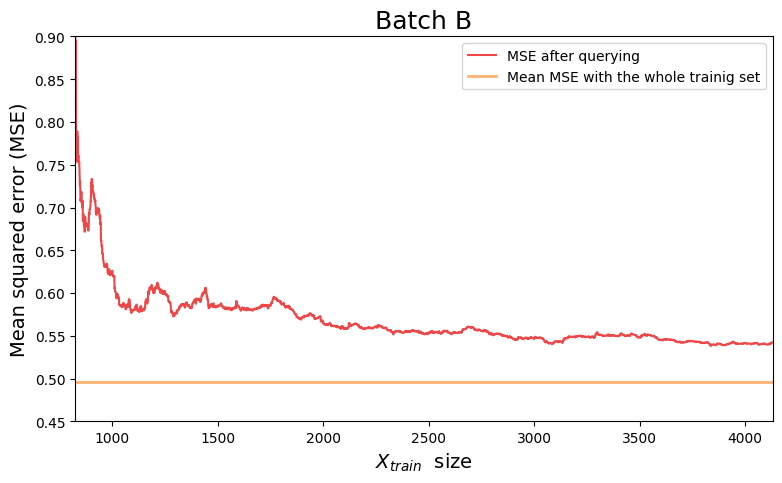

In [26]:
xxx = np.arange(825, len(x_train)+1, 1)
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(xxx, performance_history_v3, color=[.937, .275, .282], linewidth=1.5)
ax.set_ylim([0.45, 0.9])
ax.set_xlim([825, len(x_train) + 1])
plt.axhline(y = 0.4964, color=[.98, .702, .447], linestyle='-', linewidth=2)

ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=14)   
ax.set_xlabel('$X_{train}$  size', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)
ax.legend(['MSE after querying', 'Mean MSE with the whole trainig set'])

plt.savefig('Figures/AL_2_Ridge_regre_batchB.jpg',bbox_inches='tight', dpi=150)

plt.show()

### Adding conformal prediction to the best model

In [27]:
import reg_icp as ricp

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2,random_state=0)
# Split data into proper training set and clibration set
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.3,random_state=0)

In [28]:
## Ridge regression
intervals_ridge, testPred_ridge = ricp.ICPRegression(X_train, y_train, X_calib, y_calib, X_test, linear_model_v2, returnPredictions = False)

In [29]:
icp_result_ridge = pd.DataFrame(intervals_ridge,columns=['Lower_bound', 'Upper_bound'])
icp_result_ridge['y_predicted'] = testPred_ridge
icp_result_ridge['y_test'] = y_test
icp_result_ridge=icp_result_ridge.sort_values(by='y_predicted').reset_index(drop=True)

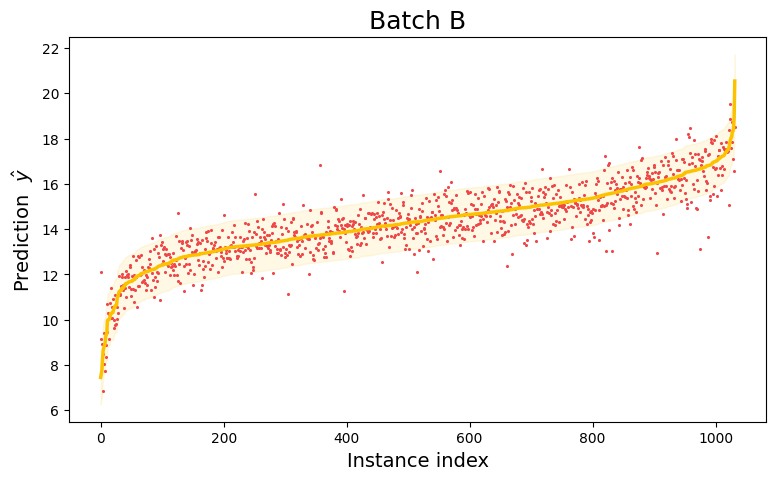

In [32]:
npoints = icp_result_ridge.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(icp_result_ridge.index[:npoints],icp_result_ridge['y_predicted'][:npoints], color=[.988, .761, 0], linewidth=2.5)
ax.fill_between(icp_result_ridge.index[:npoints],icp_result_ridge['Lower_bound'][:npoints], 
                icp_result_ridge['Upper_bound'][:npoints], color=[.988, .761, 0],alpha=0.1)
ax.scatter(icp_result_ridge.index[:npoints],icp_result_ridge['y_test'][:npoints], marker = 'o', s=2,
        color=[.937, .275, .282],linewidth=0.8)

ax.set_ylabel('Prediction  $\^y$', color="black", fontsize=14)   
ax.set_xlabel('Instance index', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)

plt.savefig('Figures/cp-al_Ridge_regre_batchB.jpg',bbox_inches='tight', dpi=150)
plt.show()